In [1]:
import numpy as np
import numba as nb

njit = nb.njit
np.random.seed(0)

# Les paramètres de l'étude. 
- La richesse initiale du porteur est de 1 euro, pour simplifier, mais aussi parce que tous les résultats sont linéaires en $W_0$.
- Le taux sans risques est celui du livret A ([Source](https://www.capital.fr/votre-argent/livret-a-ldds-lep-cel-pee-les-nouveaux-taux-de-votre-epargne-reglementee-au-1er-fevrier-2020-1361121#:~:text=Livret%20A%20%3A%20taux%20%C3%A0%200%2C5%25&text=Pour%20une%20personne%20l'ayant,de%20115%20euros%20par%20an.)).
- On prend pour référence l'ETF Lyxor CAC40 du 1er Avril 2020 au 5 mars 2021 ([Source](https://www.abcbourse.com/download/valeur/CACp)). La moyenne mensuelle des rendements $m$ et l'écart-type $\sigma$ valent $0.0215$ et $0.0613$ respectivement. Il sont calculés avec le script
```python
import pandas as pd
import numpy as np
```
```python
etf = pd.read_csv("CAC.txt", sep = ";", names = ["STOCK_ID", "DATE", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"])
etf.DATE = etf.DATE.str[:-2] + "20" + etf.DATE.str[-2:]
etf.DATE = pd.to_datetime(etf.DATE, format = "%d/%m/%Y")
etf = etf[["DATE", "STOCK_ID", "CLOSE"]]
etf = etf.rename(columns = {"CLOSE": "PRICE"})
etf = pd.pivot_table(etf, values='PRICE', index=['DATE'], columns=['STOCK_ID'])
etf = etf.resample("1D").last().interpolate().resample("1M").last()
returns = etf.copy()
for stock in returns.columns:
    returns[stock] = np.log(returns[stock]/returns[stock].shift(1)).values
```
```python
m = returns.mean().values[0]
sigma = returns.std().values[0]
```
- Le porteur modifie sa position tous les premiers du mois pendant un an, *i.e.* $K = 12$.
- Les simulations de Monte-Carlo sont faites avec $S = 1e6$ de tirages (soit un million de tirages).

In [2]:
W0 = 1            # For easier computations - results are linear anyway in W0
r = 0.005         # taux livret A
m = 0.0463        # From get-mean-std-CAC40-after-outbreak.py output
sigma = 0.0313    # From get-mean-std-CAC40-after-outbreak.py output
K = 1             # Number of years for the coupon
S = 100000         # Number of Monte-Carlo simulations

# Fonctions utiles à la simulation

- Une fonction qui simulent les rendements de l'ETF: elle prend en entrée les valeurs de $m$, $\sigma$, $K$ et $S$, elle renvoie en sortie une matrice dont les lignes sont des séries indépendantes de $(\mu_k)_{k = 0, \dots, K - 1}$ telles que $\mu_k = m + \sigma\epsilon_k$.

In [1]:
@njit(nogil=True)
def compute_mu(m, sigma, K, S):
    epsilon = np.empty((S, K))
    for s in np.arange(S):
        for k in np.arange(K):
            epsilon[s, k] = np.random.normal()
    return m + sigma*epsilon

NameError: name 'njit' is not defined

- Une fonction qui permet de calculer par itération sur $k$ de $0$ à $K - 1$ les valeurs de $\tilde{\mathcal W}_k$ à partir de la récurrence 

    $\tilde{\mathcal W}_{k + 1} = \tilde{\mathcal W}_k + \frac{\mu_k - r}{1 + r}\min(\phi, \tilde{\mathcal{W}}_k - c) - c$

    avec $\tilde{\mathcal{W}_0} = \mathcal{W}_0$. Si la fortune venait à arriver en zéro en l'instant $k$, alors pour toutes les périodes suivantes on aurait une richesse nulle également. Et ce serait la ruine de l'investisseur.
    
    Cette fonction prend en entrée les paramètres $\mathcal{W}_0$, $r$, $(\mu_k)$, $\phi$ et $c$ et renvoie en sortie une matrice dont les lignes sont des réalisations indépendantes du processus des richesses (valeurs actualisées à zéro).

In [2]:
@njit(nogil=True) # To increase performance
def compute_actualized_wealth(W0, r, mu, phi, c):
    W = np.zeros((mu.shape[0], mu.shape[1] + 1))
    W[:, 0] = W0
    for k in np.arange(mu.shape[1]):
        W[:, k + 1] = np.maximum(0, W[:, k] + (mu[:, k] - r)/(1 + r)*np.minimum(phi, W[:, k] - c) - c)
    return W

NameError: name 'njit' is not defined

- Une fonction qui calcule la probabilité 
    $P\left[ \left(\tilde{\mathcal{W}}_1\geq\frac{K}{K + 1}\tilde{\mathcal{W}}_0\right) \wedge\dots\wedge\left(\tilde{\mathcal{W}}_k\geq\frac{K - k + 1}{K + 1}\tilde{\mathcal{W}}_0\right)\wedge \dots \wedge \left(\tilde{\mathcal{W}}_K\geq\frac{1}{K + 1}\tilde{\mathcal{W}}_0\right) \right]$
    de respecter à chaque rebalancement les conditions de profitabilité par rapport à l'investissement sans risque. 
    
    Elle prend en entrée $W_0$ et la matrice des réalisation du processus des richesses successives. Elle renvoie en sortie la probabilité simulée qu'un chemins respecte la condition de profitabilité
    $\tilde{\mathcal{W}}_k\geq\frac{K - k + 1}{K + 1}\tilde{\mathcal{W}}_0$
    à chaque rebalancement.

In [3]:
@njit(nogil=True)
def compute_profitability_probability(W0, W):
    S = W.shape[0]
    K = W.shape[1] - 1
    inferior_boundary = W0*np.arange(K, 0, -1)/(K + 1)
    p = 0
    for s in np.arange(S):
        product = 1
        for k in np.arange(K):
            product *= W[s, k + 1] >= inferior_boundary[k]
        p += product
    return p/S

NameError: name 'njit' is not defined

- Une fonction qui calcule les probabilités de profitabilité pour des couples $(\varphi, c)$ compris entre $0$ et $W_0$. Le calcul est fait en discrétisant le segment $[0, \mathcal{W_0}]$ en $N_c$ segments le long de $c$ et $N_{\phi}$ segments le long de $\phi$.
    
    Elle prend en entrée les paramètres $\mathcal{W}_0$, $r$, $m$, $\sigma$, $K$, $S$ et $(N_c, N_{\phi})$. Pour ce dernier couple de paramètre, la valeur par défaut de $100$ est attribuée. La fonction renvoie en sortie une matrice des valeurs de la probabilité de profitabilité. L'axe $0$ représente $c$, l'axe $1$ représente $\phi$.

In [4]:
@njit(nogil=True)
def compute_profitability_probability_map(W0, r, m, sigma, K, S, N_phi = 100, N_c = 100):
    p = np.empty((N_c + 1, N_phi + 1))
    W = np.empty((N_c + 1, N_phi + 1, S, K + 1))
    mu = compute_mu(m, sigma, K, S)
    W0_over_N_phi = W0/N_phi
    c_over_N_c = W0/N_c
    for n_c in np.arange(N_c + 1):
        c = c_over_N_c*n_c
        for n_phi in np.arange(N_phi + 1):
            phi = W0_over_N_phi*n_phi
            W[n_c, n_phi, :, :] = compute_actualized_wealth(W0, r, mu, phi, c)
            p[n_c, n_phi] = compute_profitability_probability(W0, W[n_c, n_phi, :, :])
    return p, W

NameError: name 'njit' is not defined

- Une dernière fonction qui vient calculer pour une valeur de $c$ donnée, la valeur de $\phi$ qui sature la contrainte de profitabilité.

    Elle prend en entrée les paramètres $\mathcal{W}_0$, $r$, $m$, $sigma$, $K$ et $S$ et renvoie les valeurs prises par $(c, \phi^*)$ dans une matrice.

In [5]:
p, W = compute_profitability_probability_map(W0, r, m, sigma, K, S, 100, 100)

NameError: name 'compute_profitability_probability_map' is not defined

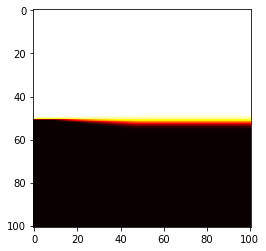

In [8]:
import pylab as plt
plt.imshow(p[:300, :], cmap='hot')
plt.show()

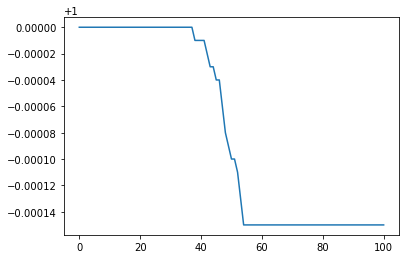

In [43]:
plt.plot(p[46, :])

In [21]:
(W[49, 50, :, 1] >= W0/2).mean()

0.97558

In [13]:
import scipy.stats as stats
s = (m - r)/sigma
1 - stats.norm.cdf(- s)

0.9064971269843487

In [23]:
inferior_boundary = W0*np.arange(K, 0, -1)/(K + 1)
inferior_boundary

array([0.5])

In [44]:
k = 0
(W[49, 50, :, k + 1] >= inferior_boundary[k]).mean()

0.97558

In [45]:
p[49, 50]

0.97558

In [51]:
W[49, 50, :, :].mean(axis = 0)

array([1.        , 0.53057156])

In [52]:
W[49, 50, :, :].std(axis = 0)/np.sqrt(S)*1.96

array([0.00000000e+00, 9.65320101e-05])

0.0413

In [55]:
8 > 5 - 3

True